# Machine Learning Demonstrations

In this notebook, we showcase how to use kdb+/q paired with embedPy to carry out machine learning tasks. Below we show how to train and test a k-nearest neighbors model to cluster data from the Wisconsin Breast Cancer dataset.

<div class="alert alert-danger">
To run the below notebook, ensure that dependencies specified in <b>requirements.txt</b> have been correctly installed.
</div>

## EmbedPy

EmbedPy allows the kdb+/q interpreter to manipulate Python objects, call Python functions and load Python libraries. Python and kdb+/q developers can fuse both technologies together, allowing for a seamless application of kdb+/q’s high-speed analytics and Python’s rich ecosystem of libraries such as scikit-learn, Tensorflow, PyTorch and Theano.

## Classification Using K-Nearest Neighbors

The k-nearest neighbors (KNN) algorithm is a simple yet effective algorithm used for supervised classification and regression problems. For a given datapoint, KNN finds the k datapoints in the training set that are closest to that point in the feature space. The prediction is then the average (for regression) or modal (for classification) value of the neighbors.

KNN is considered a non-parametric model, as it does not strictly train on the data. Instead, it retains the entire training dataset, to predict new test points. It should be noted that although KNN is considered to be non-parametric, the number of neighbors considered as an important hyperparameter to the model.

Further discussion of k-NN can be found on the [Wikipedia article](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) or [Sci-Kit Learn documentation](http://scikit-learn.org/stable/modules/neighbors.html).

## Breast Cancer Data

The [Wisconsin Breast Cancer Dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29) is a set of 569 samples of fine needle aspirate (FNA) of breast mass. Each sample contains features describing characteristics of the cell nuclei, along with a classification of the sample as either benign or malignant.

---

### Load data

In the cell below, we load in the utilities library from the kdb+/q [ML-Toolkit](https://github.com/KxSystems/ml), along with graphics functions required for this notebook. We then use embedPy to import relevant python modules and load data from the Wisconsin Breast Cancer dataset.

In [1]:
/ load toolkit and graphics functions
\l ml/ml.q
.ml.loadfile`:util/init.q

\l ../utils/graphics.q
\l ../utils/util.q

In [2]:
data:.p.import[`sklearn.datasets;`:load_breast_cancer][]
feat:data[`:data]`
targ:data[`:target]`
targnms:.p.list[<]data`:target_names
featnms:.p.list[<]data`:feature_names

/ Inspect data
-1"Shape of features is ",(" x "sv string .ml.shape feat),"\n";
show 5#feat
-1"\nMissing feature values: ",string sum where null raze feat;
-1"Missing target  values: ",string sum where null raze targ;
-1"\nDistribution of target values:\n";
show update pcnt:.util.round[;.01]100*num%sum num from select num:count i by target from([]target:targ);

Shape of features is 569 x 30

17.99 10.38 122.8 1001  0.1184  0.2776  0.3001 0.1471  0.2419 0.07871 1.095  ..
20.57 17.77 132.9 1326  0.08474 0.07864 0.0869 0.07017 0.1812 0.05667 0.5435 ..
19.69 21.25 130   1203  0.1096  0.1599  0.1974 0.1279  0.2069 0.05999 0.7456 ..
11.42 20.38 77.58 386.1 0.1425  0.2839  0.2414 0.1052  0.2597 0.09744 0.4956 ..
20.29 14.34 135.1 1297  0.1003  0.1328  0.198  0.1043  0.1809 0.05883 0.7572 ..

Missing feature values: 0
Missing target  values: 0

Distribution of target values:

target| num pcnt 
------| ---------
0     | 212 37.26
1     | 357 62.74


The output above shows that classes are quite unbalanced:
- `37%` are malignant (0)
- `63%` are benign (1)

---

### Feature scaling 

KNN needs to calculate the distance between points in the feature space, in order to identify the k nearest points. The features must therefore be standardized so they all have the same scale otherwise features with the most magnified scale would be assigned the highest weighting in terms of prediction.

Below we inspect the range of each of the 30 features in the dataset.

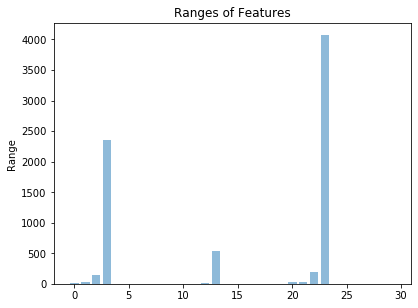

In [3]:
x:til count feat 0
y:.ml.range feat
.util.plt[`:bar][x;y;`align pykw"center";`alpha pykw .5];
.util.plt[`:ylabel]"Range";
.util.plt[`:title]"Ranges of Features";
.util.plt[`:show][];

The plot above highlights the vast difference in ranges for each of the columns so standardization will be necessary before using KNN. At this stage we scale each of the features independently to sit between 0 and 1 using `.ml.minMaxScaler`.

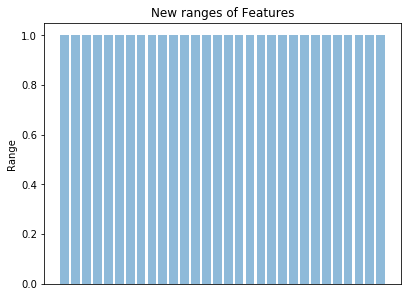

In [4]:
yscl:.ml.range each featscl:.ml.minMaxScaler.fitPredict flip feat
.util.plt[`:bar][x;yscl;`align pykw"center";`alpha pykw .5];
.util.plt[`:xticks]();
.util.plt[`:ylabel]"Range";
.util.plt[`:title]"New ranges of Features";
.util.plt[`:show][];

---

### Split data

KNN classifiers predict classes by finding the k points in the training set that are _"closest"_ to the test point in the feature space.

As such, they do not strictly _train_ on the data, instead they essentially retain all of it and uses the entire dataset to predict the classification of new test points. Implementations, including the sci-kit learn method, may build tree structures using the training data to allow optimal quering of the nearest neighbors for a test set. 

We will split the data into training and testing sets, with 50% of the data in each, and evaluate the accuracy of the classifier across a range of values for k.

In [5]:
\S 123  / random seed
show count each datadict:.ml.trainTestSplit[flip featscl;targ;.5]

xtrain| 284
ytrain| 284
xtest | 285
ytest | 285


---

### Fit and evaluate model

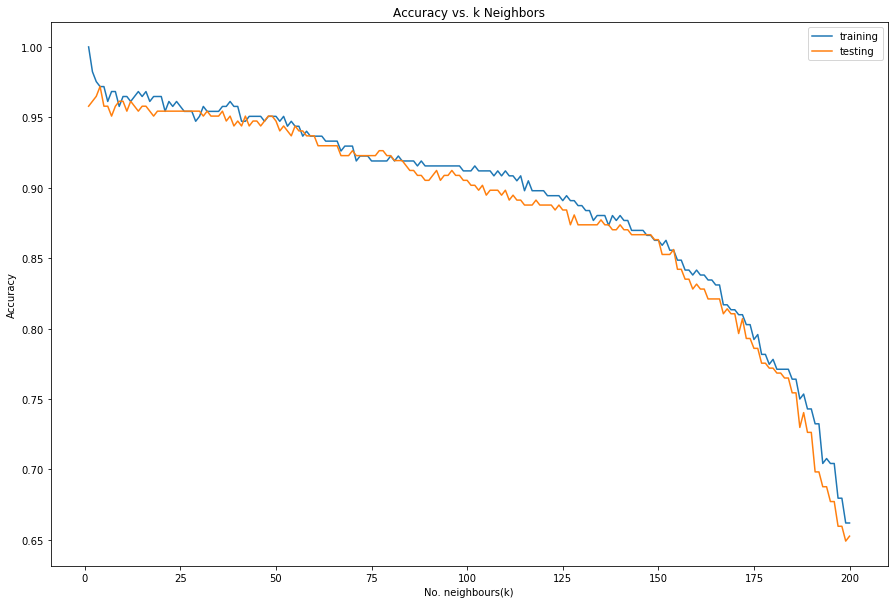

In [6]:
knn:.p.import[`sklearn.neighbors]`:KNeighborsClassifier
checkaccuracy:{[d;k] 
 clf:knn[`n_neighbors pykw k;`metric pykw"minkowski"];
 clf[`:fit]. d`xtrain`ytrain; 
 predtr:clf[`:predict][d`xtrain]`;
 predtst:clf[`:predict][d`xtest]`;
 acctr:.ml.accuracy[predtr;datadict`ytrain];
 acctst:.ml.accuracy[predtst;datadict`ytest];
 `tr`tst!(acctr;acctst)}

/ evaluate 1 <= k <= 200
accuracies:checkaccuracy[datadict]each k:1+til 200

plot:.p.wrap each`fig`ax!.util.plt[`:subplots][]`;
plot[`fig][`:set_figheight]10;
plot[`fig][`:set_figwidth]15;
plot[`ax][`:plot][k;accuracies`tr;`label pykw`training];
plot[`ax][`:plot][k;accuracies`tst;`label pykw`testing];
.util.plt[`:legend][];
.util.plt[`:xlabel]"No. neighbours(k)";
.util.plt[`:ylabel]"Accuracy";
.util.plt[`:title]"Accuracy vs. k Neighbors";
.util.plt[`:show][];

---

### Results

**k<25**:
Accuracy improves as k decreases. The training values are significantly high for low values, indicating that the model overfits the data for very low values of k. Overfitting means that the model memorizes the training data, resulting in almost perfect predictions on the training set, but the model does not generalize well to unseen data. Therefore, taking more neighbors into account will create a more generalized dataset and will improve the accuracy of predictions on the test set.

**k>25**:
Similarily in this range of k, accuracy gets worse as k increases for both the training and testing values. Beyond k=11 the model suffers due to underfitting where the model oversimplifies the distribution of the data and misses important details of the distribution. Adding more degrees-of-freedom will only make matters worse.

---

### Conclusions

The optimal choice of k for the Wisconsin Breast Cancer Dataset appears to be 25, looking at the results above.

This is an example of hyperparameter *tuning*, used to evaluate the best value of a hyperparameter. More complicated strategies (such as k-fold cross-validation) use different splits of training and validation data, increasing the overall data available for training.

The KNN classifier (with k=25) obtains 95% accuracy on the test dataset. This shows significant predictive power over the baseline strategy of always predicting the most popular class (63% accuracy).

---